In [8]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
%matplotlib inline

## Gathering Data
The code below will scrap ebay completed listings for the macbook pro. The model that we are interested in is an i5 processor, 8 gb of ram, and a 256gb ssd hard drive. These paramters are easy to change within the url itself. 

The scraper will take completed listings for years 2013-2017. This data will then be used to give us an idea of price decay by year. 

In [4]:
priceRegex = '(0-9*)</span>'

years = ['2013', '2014', '2015', '2016', '2017']
output = {}
for y in years:
    
    url = "https://www.ebay.com/sch/i.html?Screen%2520Size=13%252E3in%252E&_sop=12&_sadis=15&LH_ItemCondition=3000&Release%2520Year="+y+"&_stpos=80239-6007&_odkw=macbook+pro+retina&Memory=8GB&Hard%2520Drive%2520Capacity=256GB&_dmd=1&LH_Complete=1&_dcat=111422&LH_Sold=1&_osacat=0&_ipg=200&_from=R40&_trksid=p2045573.m570.l1313.TR0.TRC0.H0.Xmacbook+pro+retina.TRS0&_nkw=macbook+pro+retina&_sacat=0"
    r = requests.get(url)
    c = r.content

    soup = BeautifulSoup(c,"lxml")

    prices = []
    for text in soup.find_all("li", class_="lvprice prc"):
        prices.append(text.text)

    prices = [re.findall('(\d,?\d*\.\d{2}){1}',p) for p in prices if re.match('[^\$\d*\.\d{2}]',p)]

    prices = [p[0].replace(',','') for p in prices]
    final = [float(n) for n in prices]
    output[y] = final

PricesDF = pd.DataFrame({k:pd.Series(v[:200]) for k,v in output.items()})

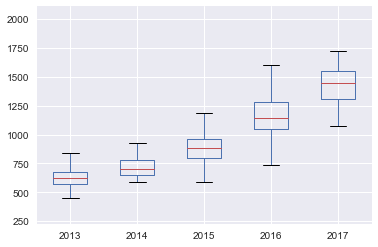

In [9]:
PricesDF.boxplot()

In [5]:
mPricesDF = pd.melt(PricesDF, value_vars=['2013', '2014', '2015', '2016', '2017'])
mPricesDF.head()

,variable,value
0,2013,625.00
1,2013,783.52
2,2013,650.07
3,2013,550.00
4,2013,610.00


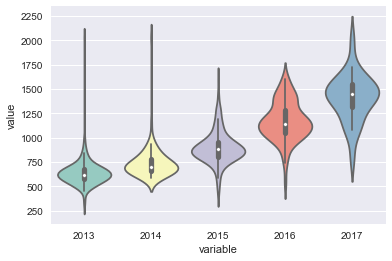

In [10]:
#violin plot of price per year 
ax = sns.violinplot(x="variable", y="value",
                    data=mPricesDF,
                    scale="width", palette="Set3")


In [12]:
#avg price per year 
pricePredict = (mPricesDF.groupby(["variable"])
                   .value
                   .mean()
                   .reset_index(name="avgPrice"))

pricePredict['variable'] = pricePredict['variable'].apply(int)
pricePredict['year'] = pricePredict['variable'].apply(str)

pricePredict.head()


,variable,avgPrice,year
0,2013,636.962350,2013
1,2014,740.359000,2014
2,2015,897.702300,2015
3,2016,1170.525714,2016
4,2017,1411.621154,2017


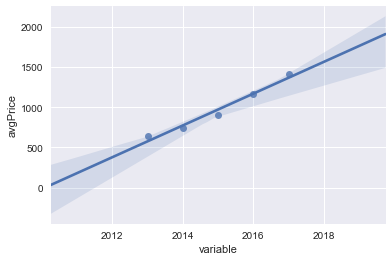

In [13]:
#plot lm fit 
sns.regplot(x="variable", y="avgPrice", data=pricePredict)

In [15]:
#lm 
lmod = smf.ols(formula='avgPrice ~ year', data=pricePredict)
res = lmod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               avgPrice   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Wed, 22 Nov 2017   Prob (F-statistic):                nan
Time:                        20:27:44   Log-Likelihood:                 133.36
No. Observations:                   5   AIC:                            -256.7
Df Residuals:                       0   BIC:                            -258.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept      636.9623        inf          0   

C:\Users\Dave\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n))
C:\Users\Dave\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1187: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - np.divide(self.nobs - self.k_constant, self.df_resid) * (1 - self.rsquared)
C:\Users\Dave\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1187: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - np.divide(self.nobs - self.k_constant, self.df_resid) * (1 - self.rsquared)
C:\Users\Dave\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1195: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
C:\Users\Dave\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1148: RuntimeWarning: divide by zero encountered in double_scalar